In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import seaborn as sns
import pmdarima as pm

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


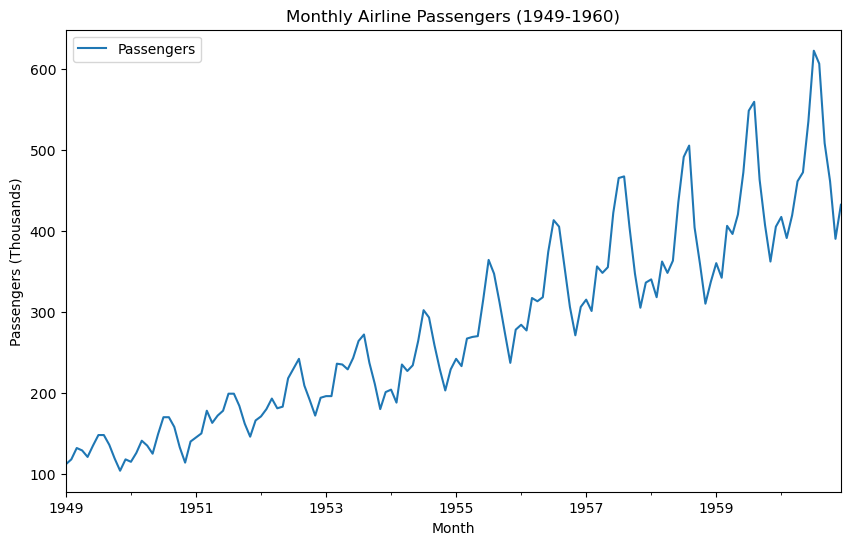

In [2]:
# Load the dataset
url = (
    "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
)
data = pd.read_csv(url, parse_dates=["Month"], index_col="Month")

# Display the first few rows
print(data.head())

# Plot the data
data.plot(figsize=(10, 6), title="Monthly Airline Passengers (1949-1960)")
plt.xlabel("Month")
plt.ylabel("Passengers (Thousands)")
plt.show()

In [3]:
data.index = pd.DatetimeIndex(data.index, freq="MS")

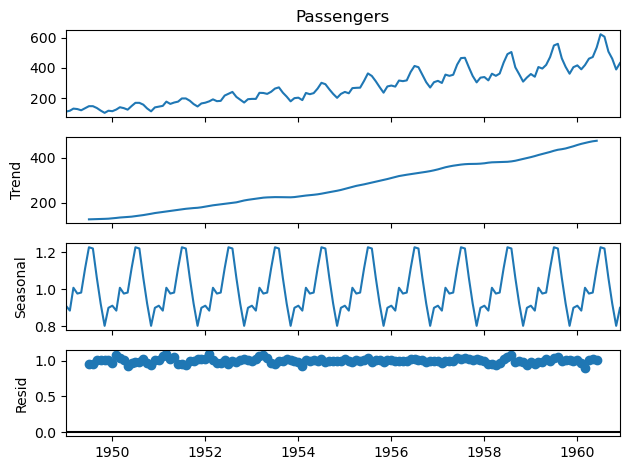

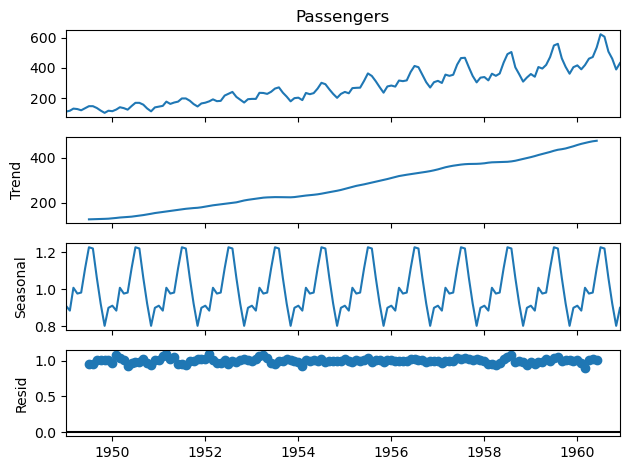

In [4]:
# Perform decomposition
decomposition = seasonal_decompose(data["Passengers"], model="multiplicative")

# Plot decomposition
decomposition.plot()

In [5]:
def diff_plot(data_df, diff_order):
    # First-order differencing
    data_diff = data_df.diff(diff_order).dropna()

    # Plot differenced data
    data_diff.plot(figsize=(10, 6), title="Differenced Airline Passengers")
    plt.show()

    # Recheck stationarity
    result_diff = adfuller(data_diff["Passengers"])
    print(f"ADF Statistic (Differenced): {result_diff[0]}")
    print(f"p-value (Differenced): {result_diff[1]}")
    return data_diff

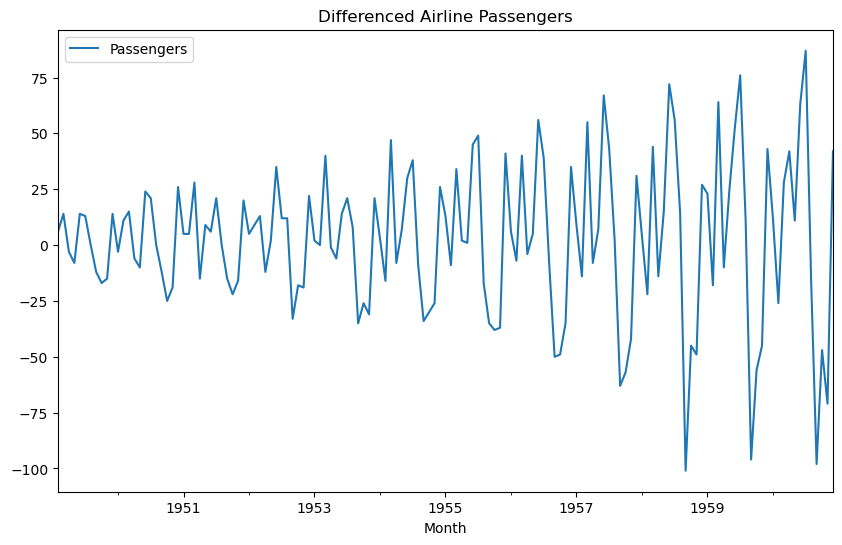

ADF Statistic (Differenced): -2.829266824169981
p-value (Differenced): 0.05421329028382793


In [6]:
data_diff = diff_plot(data, 1)

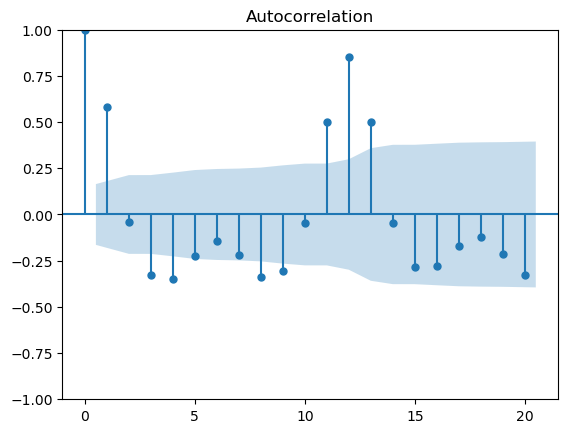

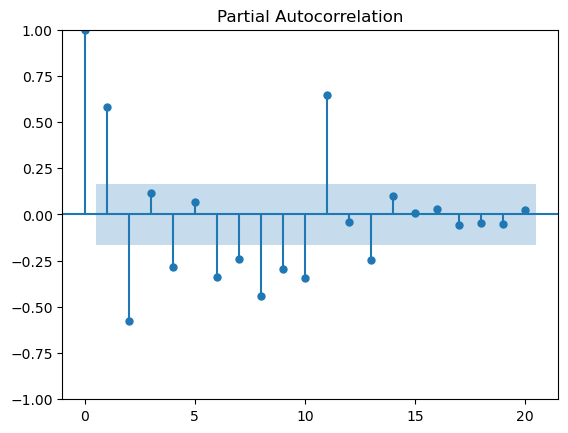

In [8]:
# ACF and PACF plots
plot_acf(data_diff, lags=20)
plt.show()

plot_pacf(data_diff, lags=20)
plt.show()

Spikes in ACF and PACF at 1, 2 and 12 suggest seasonality  
This means that SARIMA model would be more appropriate than ARIMA model

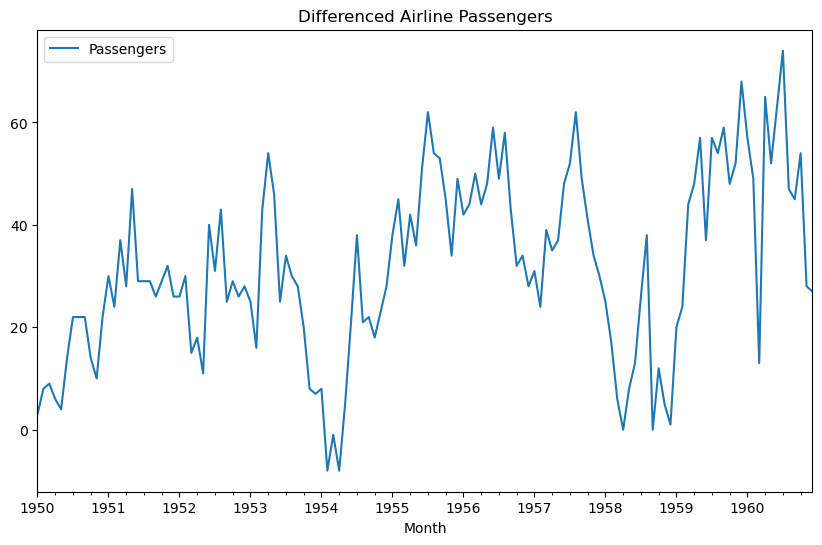

ADF Statistic (Differenced): -3.383020726492481
p-value (Differenced): 0.011551493085514954


In [9]:
# Seasonal differencing (lag 12)
data_seasonal_diff = diff_plot(data, 12)

p value < 0.05 -> differenced data stationary

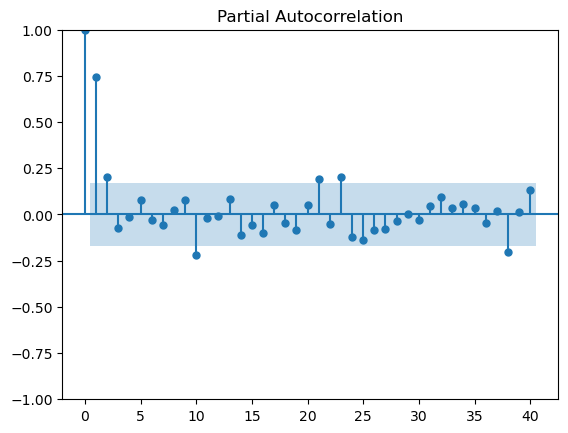

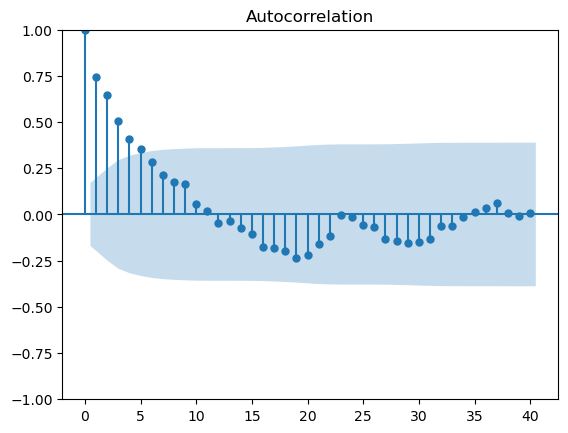

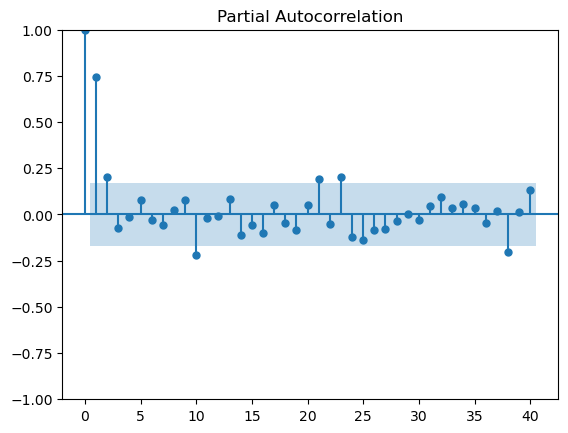

In [10]:
plot_acf(data_seasonal_diff, lags=40)
plot_pacf(data_seasonal_diff, lags=40)

/Users/ahmed/miniconda3/envs/ML/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ahmed/miniconda3/envs/ML/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ahmed/miniconda3/envs/ML/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/ahmed/miniconda3/envs/ML/lib/python3.12/site-packages/sta


Model Comparison:
                              RMSE        MAE      MAPE        Aicc
SARIMA(1,1,0)(0,1,0,12)  35.082720  28.547318  6.124530  755.620578
SARIMA(1,1,3)(1,1,3,12)  20.517666  16.733739  3.701025  756.180429
SARIMA(2,1,3)(1,1,3,12)  25.504292  21.483695  4.681604  756.139443
SARIMA(2,1,3)(2,1,3,12)  30.246929  25.282822  5.497495  761.057301
SARIMA(3,1,1)(2,1,3,12)  18.057419  14.399847  3.224640  758.440506
SARIMA(3,1,2)(0,1,1,12)  34.781011  28.268916  6.041180  760.174913
SARIMA(2,1,3)(0,1,3,12)  34.669876  28.445064  6.108474  760.943165


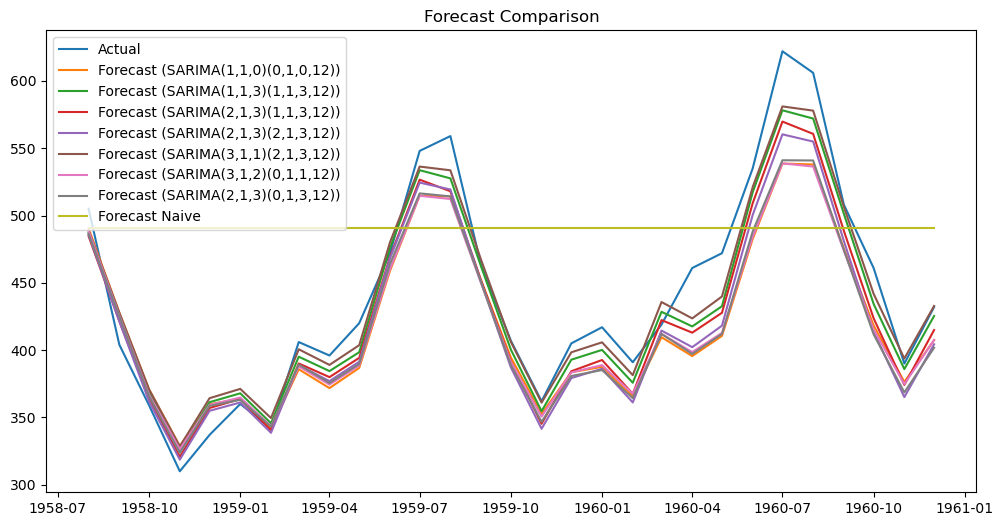

In [222]:
# 1. Prepare train/test split
train_size = int(len(data) * 0.8)
train = data[:train_size]
test = data[train_size:]

# 2. Define and fit multiple models for comparison
models = [
    {
        "order": (1, 1, 0),
        "seasonal_order": (0, 1, 0, 12),
        "name": "SARIMA(1,1,0)(0,1,0,12)",
    },
    {
        "order": (1, 1, 3),
        "seasonal_order": (1, 1, 3, 12),
        "name": "SARIMA(1,1,3)(1,1,3,12)",
    },
    {
        "order": (2, 1, 3),
        "seasonal_order": (1, 1, 3, 12),
        "name": "SARIMA(2,1,3)(1,1,3,12)",
    },
    {
        "order": (2, 1, 3),
        "seasonal_order": (2, 1, 3, 12),
        "name": "SARIMA(2,1,3)(2,1,3,12)",
    },
    {
        "order": (3, 1, 1),
        "seasonal_order": (2, 1, 3, 12),
        "name": "SARIMA(3,1,1)(2,1,3,12)",
    },
    {
        "order": (3, 1, 2),
        "seasonal_order": (0, 1, 1, 12),
        "name": "SARIMA(3,1,2)(0,1,1,12)",
    },
    {
        "order": (2, 1, 3),
        "seasonal_order": (0, 1, 3, 12),
        "name": "SARIMA(2,1,3)(0,1,3,12)",
    },
]

results_dict = {}
result_model = []
for model_params in models:
    model = SARIMAX(
        train["Passengers"],
        order=model_params["order"],
        seasonal_order=model_params["seasonal_order"],
        freq="MS",
    )
    model_fit = model.fit(method="powell", maxiter=1000, disp=False)
    result_model.append(model_fit)
    # Make predictions
    forecast = model_fit.get_forecast(steps=len(test))
    predicted_mean = forecast.predicted_mean

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(test["Passengers"], predicted_mean))
    mae = mean_absolute_error(test["Passengers"], predicted_mean)
    mape = (
        np.mean(np.abs((test["Passengers"] - predicted_mean) / test["Passengers"]))
        * 100
    )
    aicc = model_fit.aicc
    results_dict[model_params["name"]] = {
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "forecast": predicted_mean,
        "aicc": aicc,
    }

# 3. Compare results
comparison_df = pd.DataFrame(
    {
        model_name: {
            "RMSE": results["rmse"],
            "MAE": results["mae"],
            "MAPE": results["mape"],
            "Aicc": results["aicc"],
        }
        for model_name, results in results_dict.items()
    }
).T

print("\nModel Comparison:")
print(comparison_df)

# 4. Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(test.index, test["Passengers"], label="Actual")
for model_name, results in results_dict.items():
    plt.plot(test.index, results["forecast"], label=f"Forecast ({model_name})")
# plot naive approach model
naive_forecast = test.copy()
naive_forecast["Predicted"] = train["Passengers"].iloc[
    -1
]  # Using last train value for all test
plt.plot(test.index, naive_forecast["Predicted"], label="Forecast Naive")
plt.legend()
plt.title("Forecast Comparison")
plt.show()

Judging by error metrics and Aicc we compare second model and the last model

In [223]:
final_model = result_model[1]
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 12)   Log Likelihood                -368.112
Date:                            Sun, 02 Feb 2025   AIC                            754.224
Time:                                    10:39:38   BIC                            777.849
Sample:                                01-01-1949   HQIC                           763.790
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8597      0.128      6.699      0.000       0.608       1.111
ma.L1         -1.1014      0.137     -8.024      0.000      -1.370      -0.832
ma.L2          0.2430      0.164      1.484      0.138      -0.078       0.564
ma.L3         -0.1348      0.158     -0.853      0.394      -0.445       0.175
ar.S.L12       0.8945      0.365      2.449      0.014       0.179       1.610
ma.S.L12      -1.1460      0.507     -2.262      0.024      -2.139      -0.153
ma.S.L24       0.2443      0.194      1.262      0.207      -0.135       0.624
ma.S.L36       0.1399      0.168      0.833      0.405      -0.189       0.469
sigma2        73.1078     16.705      4.376      0.000      40.366     105.850
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.75   Prob(JB):                         0.36
Heteroskedasticity (H):               0.96   Skew:                             0.34
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [228]:
final_model = result_model[4]
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                 Passengers   No. Observations:                  115
Model:             SARIMAX(3, 1, 1)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -368.011
Date:                                    Sun, 02 Feb 2025   AIC                            756.023
Time:                                            10:39:59   BIC                            782.273
Sample:                                        01-01-1949   HQIC                           766.652
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7183      0.182      3.946      0.000       0.362       1.075
ar.L2          0.2482      0.158      1.567      0.117      -0.062       0.559
ar.L3         -0.1264      0.131     -0.963      0.335      -0.384       0.131
ma.L1         -0.9796      0.486     -2.018      0.044      -1.931      -0.028
ar.S.L12       0.1304      0.512      0.254      0.799      -0.874       1.135
ar.S.L24       0.8661      0.941      0.921      0.357      -0.978       2.710
ma.S.L12      -0.4839      1.697     -0.285      0.775      -3.810       2.842
ma.S.L24      -0.8044      2.282     -0.353      0.724      -5.277       3.668
ma.S.L36       0.3384      0.994      0.340      0.734      -1.610       2.286
sigma2        67.0423    148.561      0.451      0.652    -224.131     358.216
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.93   Prob(JB):                         0.40
Heteroskedasticity (H):               1.06   Skew:                             0.33
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model number 1 has more significant paramaters so will go with it

In [ ]:
final_model = result_model[1]

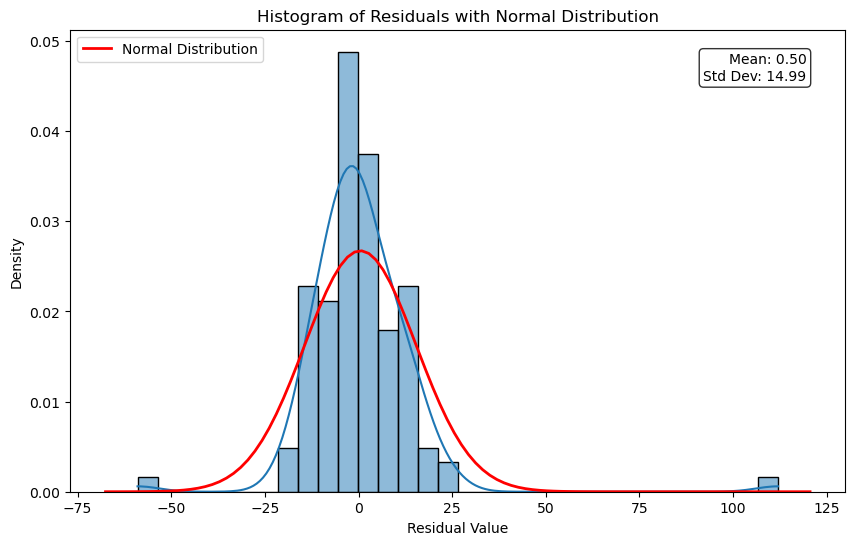

In [225]:
# Get residuals and create histogram
residuals = final_model.resid
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram with KDE
sns.histplot(residuals, kde=True, stat="density", ax=ax)

# Add normal distribution overlay for comparison
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
ax.plot(x, p, "r-", lw=2, label="Normal Distribution")

# Add labels and title
ax.set_title("Histogram of Residuals with Normal Distribution")
ax.set_xlabel("Residual Value")
ax.set_ylabel("Density")
ax.legend()

# Add statistics annotation
stats_text = f"Mean: {residuals.mean():.2f}\nStd Dev: {residuals.std():.2f}"
ax.text(
    0.95,
    0.95,
    stats_text,
    transform=ax.transAxes,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.show()

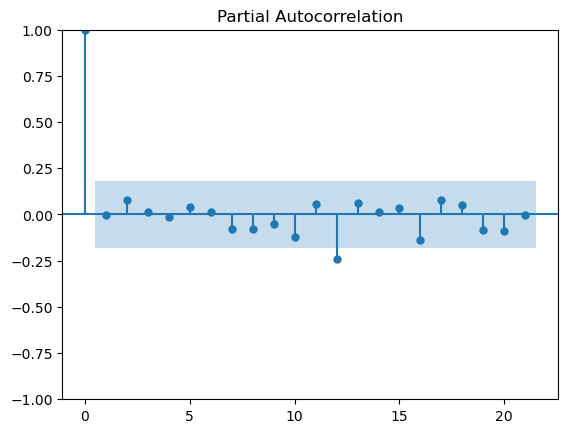

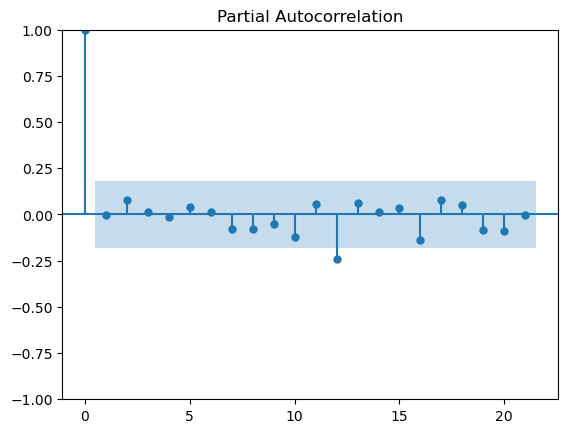

In [226]:
plot_pacf(residuals)

Now we make sure residuals are uncorrelated using accor ljungbox test


Ljung-Box Test Results:
      lb_stat  lb_pvalue
1    0.002237   0.962278
2    0.704590   0.703073
3    0.724734   0.867371
4    0.735570   0.946871
5    0.928449   0.968128
6    0.949127   0.987467
7    1.562310   0.980074
8    2.290250   0.970796
9    2.790904   0.972011
10   5.031223   0.889083
11   5.381943   0.911269
12  13.972818   0.302447
13  14.371884   0.348185
14  14.400787   0.420299
15  14.547666   0.484463
16  15.959414   0.455797
17  16.700018   0.474862
18  17.011475   0.522316
19  17.149155   0.579764
20  17.247599   0.636842


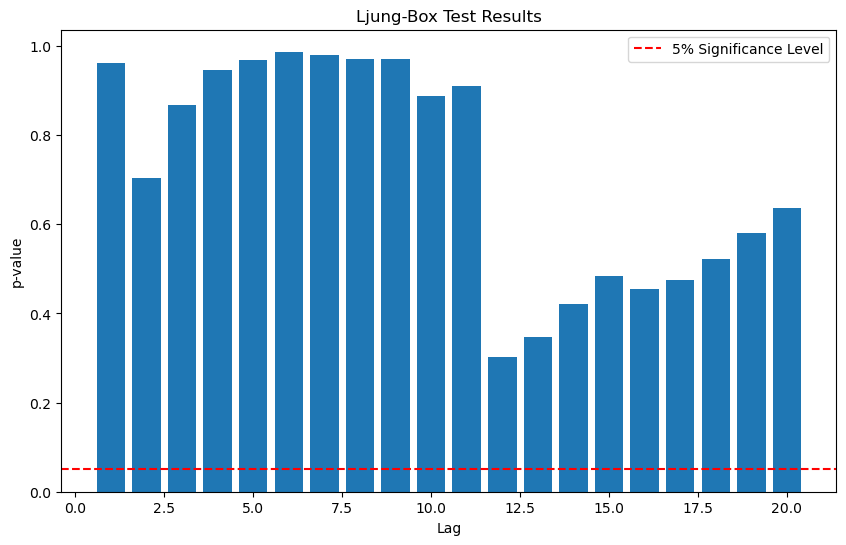

Residuals are uncorrelated (p-value = 0.6368)


In [227]:
lb_test = acorr_ljungbox(residuals, lags=20, return_df=True)
# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(lb_test.index, lb_test["lb_pvalue"])
ax.axhline(y=0.05, color="r", linestyle="--", label="5% Significance Level")
ax.set_xlabel("Lag")
ax.set_ylabel("p-value")
ax.set_title("Ljung-Box Test Results")
ax.legend()

# Print test results
print("\nLjung-Box Test Results:")
print(lb_test)

plt.show()
p_value = lb_test.iloc[-1, 1]  # Last row corresponds to lag 40
if p_value > 0.05:
    print(f"Residuals are uncorrelated (p-value = {p_value:.4f})")
else:
    print(f"Residuals are correlated (p-value = {p_value:.4f})")